In [ ]:
import os
from glob import glob
 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
 
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
import keras.backend as K
 
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/My Drive/np.zip' -d '/content/'

Mounted at /content/drive
Archive:  /content/drive/My Drive/np.zip
  inflating: /content/np/256_192_test.npy  
  inflating: /content/np/256_192_train.npy  
  inflating: /content/np/256_192_val.npy  
  inflating: /content/np/test_labels.npy  
  inflating: /content/np/train_labels.npy  
  inflating: /content/np/val_labels.npy  


## Load in the Dataset

In [ ]:
X_train = np.load("np/256_192_train.npy")

In [ ]:
y_train = np.load("np/train_labels.npy")

In [ ]:
X_val = np.load("np/256_192_val.npy")

In [ ]:
y_val = np.load("np/val_labels.npy")

In [ ]:
X_train.shape, X_val.shape

((8111, 192, 256, 3), (902, 192, 256, 3))

In [ ]:
y_train.shape, y_val.shape

((8111,), (902,))

In [ ]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [ ]:
y_train.shape, y_val.shape

((8111, 7), (902, 7))

## Load Pretrained Model

In [ ]:
pre_trained_model = InceptionResNetV2(input_shape=(192, 256, 3), include_top=False, weights="imagenet")

219062272/219055592 [==============================] - 5s 0us/step


In [ ]:
for layer in pre_trained_model.layers:
    print(layer.name)
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False

print(len(pre_trained_model.layers))

input_1
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
activation_4
max_pooling2d_1
conv2d_8
batch_normalization_8
activation_8
conv2d_6
conv2d_9
batch_normalization_6
batch_normalization_9
activation_6
activation_9
average_pooling2d
conv2d_5
conv2d_7
conv2d_10
conv2d_11
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
activation_5
activation_7
activation_10
activation_11
mixed_5b
conv2d_15
batch_normalization_15
activation_15
conv2d_13
conv2d_16
batch_normalization_13
batch_normalization_16
activation_13
activation_16
conv2d_12
conv2d_14
conv2d_17
batch_normalization_12
batch_normalization_14
batch_normalization_17
activation_12
activation_14
activation_17
block35_1_mixed
block35_1_conv
block35_1
block35_1_ac
conv2d_21
batch_normalization_21
activation_21
conv2d_19
conv2d_22
batc

In [ ]:
last_layer = pre_trained_model.get_layer('conv_7b_ac')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 4, 6, 1536)


## Define the Model

In [ ]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.7
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 95, 127, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 95, 127, 32)  96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 95, 127, 32)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Training

### Feature Extraction

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [ ]:
batch_size = 64
epochs = 3
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
                              validation_steps=(X_val.shape[0] // batch_size))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
126/126 [==============================] - 290s 2s/step - loss: 1.7265 - accuracy: 0.5615 - val_loss: 3.9584 - val_accuracy: 0.6295
Epoch 2/3
126/126 [==============================] - 220s 2s/step - loss: 1.0530 - accuracy: 0.6770 - val_loss: 0.9722 - val_accuracy: 0.7009
Epoch 3/3
126/126 [==============================] - 220s 2s/step - loss: 1.0032 - accuracy: 0.6777 - val_loss: 1.0121 - val_accuracy: 0.6719


### Fine Tuning

In [ ]:
pre_trained_model.layers[617].name

'mixed_7a'

In [ ]:
for layer in pre_trained_model.layers:
    layer.trainable = True

In [ ]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 95, 127, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 95, 127, 32)  96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 95, 127, 32)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
batch_size = 64
epochs = 20
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
126/126 [==============================] - 342s 3s/step - loss: 0.8773 - acc: 0.7031 - val_loss: 0.7174 - val_acc: 0.7455
Epoch 2/20
126/126 [==============================] - 314s 2s/step - loss: 0.6058 - acc: 0.7855 - val_loss: 0.5629 - val_acc: 0.8103
Epoch 3/20
126/126 [==============================] - 314s 2s/step - loss: 0.4888 - acc: 0.8235 - val_loss: 0.5011 - val_acc: 0.8103
Epoch 4/20
126/126 [==============================] - 313s 2s/step - loss: 0.4033 - acc: 0.8565 - val_loss: 0.4764 - val_acc: 0.8326
Epoch 5/20
126/126 [==============================] - 313s 2s/step - loss: 0.3150 - acc: 0.8849 - val_loss: 0.6176 - val_acc: 0.8192
Epoch 6/20
126/126 [==============================] - 313s 2s/step - loss: 0.2795 - acc: 0.9011 - val_loss: 0.4219 - val_acc: 0.8616
Epoch 7/20
126/126 [==============================] - 313s 2s/step - loss: 0.2376 - acc: 0.9169 - val_loss: 0.4174 - val_acc: 0.8661
Epoch 8/20
126/126 [==============================] - 314s 2s/step - 

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=1)

In [ ]:
 model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                     epochs = 5, validation_data = val_datagen.flow(X_val, y_val),
                     verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                     validation_steps=(X_val.shape[0] // batch_size),
                     callbacks=[learning_rate_reduction])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
126/126 [==============================] - 314s 2s/step - loss: 0.0253 - acc: 0.9928 - val_loss: 0.7462 - val_acc: 0.8549
Epoch 2/5
126/126 [==============================] - 314s 2s/step - loss: 0.0246 - acc: 0.9929 - val_loss: 0.7355 - val_acc: 0.8683
Epoch 3/5
126/126 [==============================] - 314s 2s/step - loss: 0.0193 - acc: 0.9935 - val_loss: 0.9045 - val_acc: 0.8504
Epoch 4/5
126/126 [==============================] - 314s 2s/step - loss: 0.0244 - acc: 0.9923 - val_loss: 0.7514 - val_acc: 0.8661

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
Epoch 5/5
126/126 [==============================] - 314s 2s/step - loss: 0.0163 - acc: 0.9945 - val_loss: 0.6335 - val_acc: 0.8750


In [ ]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

29/29 [==============================] - 16s 425ms/step - loss: 0.6922 - acc: 0.8703
Validation: accuracy = 0.870288  ;  loss_v = 0.692238


## Testing

In [ ]:
X_test = np.load("np/256_192_test.npy")

In [ ]:
y_test = np.load("np/test_labels.npy")
y_test = to_categorical(y_test)

In [ ]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

32/32 [==============================] - 14s 427ms/step - loss: 0.7141 - acc: 0.8743
Test: accuracy = 0.874251  ;  loss = 0.714055


In [ ]:
model.save("InceptionResNet.h5")

In [ ]:
!zip "/content/model.zip" "/content/InceptionResNet.h5"

  adding: content/InceptionResNet.h5 (deflated 10%)


In [ ]:
!mv "/content/model.zip" "/content/drive/My Drive/"

Text(0.5, 1.0, 'Training and validation loss')

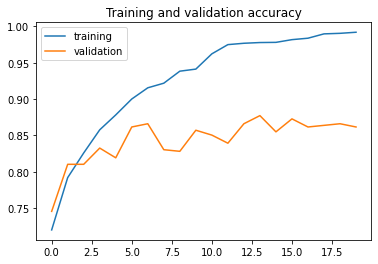

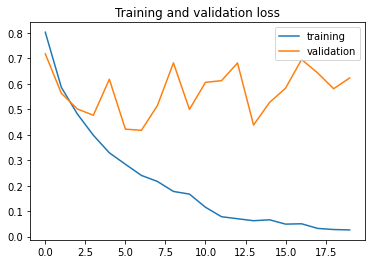

In [ ]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')